In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Unzip dataset
!unzip "/content/drive/MyDrive/Flood_Segmentation/archive.zip" -d "/content/drive/MyDrive/Flood_Segmentation/archive"

Archive:  /content/drive/MyDrive/Flood_Segmentation/archive.zip
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/Image/0.jpg  
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/Image/1.jpg  
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/Image/10.jpg  
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/Image/1000.jpg  
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/Image/1001.jpg  
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/Image/1002.jpg  
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/Image/1003.jpg  
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/Image/1004.jpg  
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/Image/1005.jpg  
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/Image/1006.jpg  
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/Image/1007.jpg  
  inflating: /content/drive/MyDrive/Flood_Segmentation/archive/I

Device: cuda
Training for 40 epochs (start_epoch=0)...
Epoch 1/40 | Train Loss: 0.8034 | Val Loss: 2.7449 | Val Dice: 0.5118 | Val IoU: 0.3474
✅ Saved checkpoint: ./checkpoints/unet_best.pth
Epoch 2/40 | Train Loss: 0.7248 | Val Loss: 0.6669 | Val Dice: 0.7542 | Val IoU: 0.6079
✅ Saved checkpoint: ./checkpoints/unet_best.pth
Epoch 3/40 | Train Loss: 0.6908 | Val Loss: 0.6235 | Val Dice: 0.7784 | Val IoU: 0.6413
✅ Saved checkpoint: ./checkpoints/unet_best.pth
Epoch 4/40 | Train Loss: 0.6453 | Val Loss: 1.1156 | Val Dice: 0.5009 | Val IoU: 0.3411
Epoch 5/40 | Train Loss: 0.6222 | Val Loss: 0.7307 | Val Dice: 0.7714 | Val IoU: 0.6335
Epoch 6/40 | Train Loss: 0.6426 | Val Loss: 1.9532 | Val Dice: 0.0377 | Val IoU: 0.0196
Epoch 7/40 | Train Loss: 0.6345 | Val Loss: 0.7921 | Val Dice: 0.7433 | Val IoU: 0.5960
⚡ LR reduced from 0.001000 → 0.000500
Epoch 8/40 | Train Loss: 0.5685 | Val Loss: 0.5412 | Val Dice: 0.8188 | Val IoU: 0.6961
✅ Saved checkpoint: ./checkpoints/unet_best.pth
Epoch 9/40 

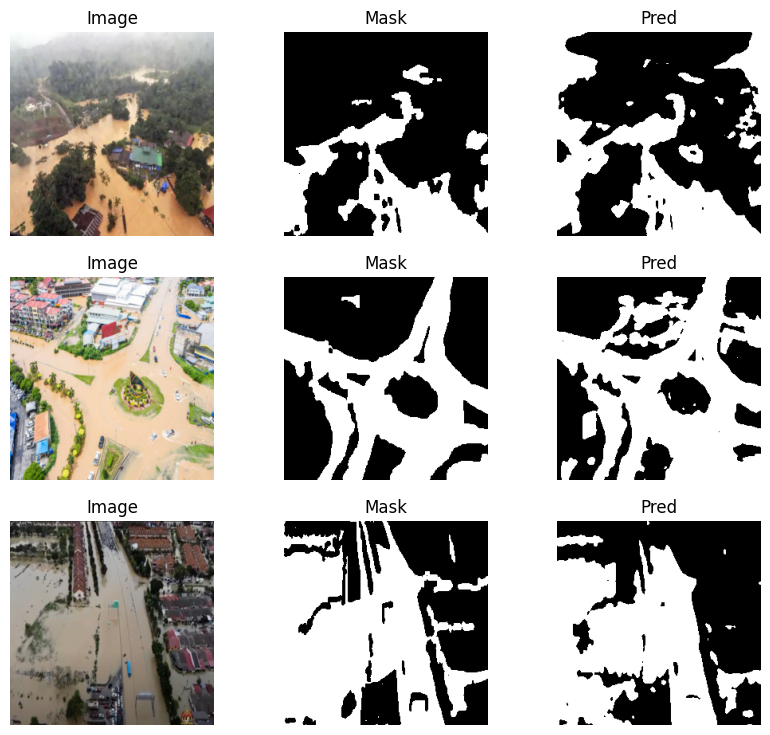

In [ ]:
# ============================================================
# Flood Segmentation with U-Net
# ============================================================
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# ============================================================
# 1. Dataset
# ============================================================
class FloodDataset(Dataset):
    def __init__(self, root, img_size=256, split="train", val_ratio=0.2):
        self.img_dir = os.path.join(root, "Image")
        self.mask_dir = os.path.join(root, "Mask")

        self.img_size = img_size
        self.images = sorted(os.listdir(self.img_dir))

        # train/val split
        n_val = int(len(self.images) * val_ratio)
        if split == "train":
            self.images = self.images[:-n_val]
        else:
            self.images = self.images[-n_val:]

        self.img_transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])
        self.mask_transform = T.Compose([
            T.Resize((img_size, img_size), interpolation=T.InterpolationMode.NEAREST),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # ensure mask is .png
        base_name = os.path.splitext(img_name)[0]
        mask_path = os.path.join(self.mask_dir, base_name + ".png")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = self.img_transform(image)
        mask = self.mask_transform(mask)
        mask = (mask > 0.5).float()  # binarize

        return image, mask

# ============================================================
# 2. Model (U-Net)
# ============================================================
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5)
        x = self.conv1(torch.cat([x, x4], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x3], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x2], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x, x1], dim=1))
        return self.outc(x)

# ============================================================
# 3. Loss & Metrics
# ============================================================
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.smooth = smooth

    def forward(self, preds, targets):
        bce_loss = self.bce(preds, targets)

        preds = torch.sigmoid(preds)
        preds_flat = preds.view(-1)
        targets_flat = targets.view(-1)

        intersection = (preds_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (
            preds_flat.sum() + targets_flat.sum() + self.smooth
        )
        return bce_loss + dice_loss

def dice_coef(preds, targets, smooth=1.0):
    preds = torch.sigmoid(preds) > 0.5
    preds = preds.float()
    targets = targets.float()
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets, smooth=1.0):
    preds = torch.sigmoid(preds) > 0.5
    preds = preds.float()
    targets = targets.float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# ============================================================
# 4. Checkpoints
# ============================================================
def save_checkpoint(model, optimizer, epoch, path="checkpoint.pth"):
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"✅ Saved checkpoint: {path}")

def load_checkpoint(path, model, optimizer=None, device="cuda"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state"])
    print(f"✅ Loaded checkpoint from {path} (epoch {checkpoint['epoch']})")
    return checkpoint["epoch"] + 1

# ============================================================
# 5. Training
# ============================================================
def train_model(root, img_size=256, batch_size=8, num_epochs=40, lr=1e-3,
                patience=5, resume_checkpoint=None, save_dir="./checkpoints",
                device="cuda"):
    os.makedirs(save_dir, exist_ok=True)

    train_ds = FloodDataset(root, img_size=img_size, split="train")
    val_ds = FloodDataset(root, img_size=img_size, split="val")
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    model = UNet().to(device)
    criterion = DiceBCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    # AMP scaler (new API style)
    scaler = torch.amp.GradScaler("cuda", enabled=(device.startswith("cuda")))

    start_epoch, best_dice, epochs_no_improve = 0, 0, 0

    if resume_checkpoint:
        start_epoch = load_checkpoint(resume_checkpoint, model, optimizer, device=device)

    print(f"Device: {device}")
    print(f"Training for {num_epochs} epochs (start_epoch={start_epoch})...")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast("cuda", enabled=(device.startswith("cuda"))):
                preds = model(images)
                loss = criterion(preds, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        # validation
        model.eval()
        val_loss, val_dice, val_iou = 0, 0, 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                preds = model(images)
                loss = criterion(preds, masks)
                val_loss += loss.item()
                val_dice += dice_coef(preds, masks).item()
                val_iou += iou_score(preds, masks).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Dice: {val_dice:.4f} | "
              f"Val IoU: {val_iou:.4f}")

        # LR schedule (with manual print)
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_dice)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr != old_lr:
            print(f"⚡ LR reduced from {old_lr:.6f} → {new_lr:.6f}")

        # save best model
        if val_dice > best_dice:
            best_dice = val_dice
            save_checkpoint(model, optimizer, epoch, os.path.join(save_dir, "unet_best.pth"))
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("⏹ Early stopping triggered.")
                break

        # save periodic checkpoint
        if (epoch + 1) % 10 == 0:
            save_checkpoint(model, optimizer, epoch, os.path.join(save_dir, f"unet_epoch{epoch+1}.pth"))

    print(f"✅ Training done. Best Dice: {best_dice:.4f}")
    return model, best_dice

# ============================================================
# 6. Visualization
# ============================================================
def visualize_predictions(model, dataset, device="cuda", num_samples=3):
    model.eval()
    idxs = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples*3))
    if num_samples == 1: axes = [axes]

    for i, idx in enumerate(idxs):
        img, mask = dataset[idx]
        img_in = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = torch.sigmoid(model(img_in))
        pred = (pred > 0.5).float().cpu().squeeze().numpy()

        axes[i][0].imshow(img.permute(1, 2, 0))
        axes[i][0].set_title("Image")
        axes[i][1].imshow(mask.squeeze(), cmap="gray")
        axes[i][1].set_title("Mask")
        axes[i][2].imshow(pred, cmap="gray")
        axes[i][2].set_title("Pred")
        for ax in axes[i]: ax.axis("off")
    plt.show()

# ============================================================
# 7. Run Training
# ============================================================
root = "/content/drive/MyDrive/Flood_Segmentation/archive"
assert os.path.exists(root), f"Root path not found: {root}"

model, best_score = train_model(
    root=root,
    img_size=256,
    batch_size=8,
    num_epochs=40,
    lr=1e-3,
    patience=5,
    save_dir="./checkpoints",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# visualize results
val_ds = FloodDataset(root, img_size=256, split="val")
visualize_predictions(model, val_ds, num_samples=3)